## Traininig the Inclusive classifier with tf.keras using data in TFRecord format

**tf.keras Inclusive classifier, LSTM-based model** This notebooks trains a neural network for the particle classifier using the Inclusive Classifier, using as input the full list of recunstructed particles and the High Level Features. Data is prepared in TFRecord format converting from Parquet using Apache Spark. Tensorflow data procesing uses tf.data and tf.io.  
This notebook uses an LSTM layer instead of GRU in the neural network for the Inclusive classifier

Credits: this notebook is part of the work: 
- [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
- Code and data at:https://github.com/cerndb/SparkDLTrigger  

The model is a classifier implemented as the concatenation of a Dense Neural Network and a Recurrent Neural Network (LSTM)
 - input: 14 high-level features and an array of 801 particles with 19 low-level features, described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
 - output: 3 classes, "W + jet", "QCD", "t tbar", see also [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
 - Open dataset: [download data](https://github.com/cerndb/SparkDLTrigger/tree/master/Data)


## Create the Keras model for the inclusive classifier

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Masking, Dense, Activation, Dropout, concatenate, LSTM

In [2]:
tf.version.VERSION

'2.8.0'

In [3]:
# Check that we have a GPU available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
## LSTM branch
lstm_input = Input(shape=(801,19), name='lstm_input')
a = lstm_input
a = Masking(mask_value=0.)(a)
a = LSTM(units=50,activation='tanh')(a)
lstmBranch = Dropout(0.2)(a)


In [5]:
hlf_input = Input(shape=(14,), name='hlf_input')
b = hlf_input
hlfBranch = Dropout(0.2)(b)

In [6]:
c = concatenate([lstmBranch, hlfBranch])
c = Dense(25, activation='relu')(c)
output = Dense(3, activation='softmax')(c)

In [7]:
model = Model(inputs=[lstm_input, hlf_input], outputs=output)

In [8]:
## Compile model
optimizer = 'Adam'
loss = 'categorical_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"] )

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lstm_input (InputLayer)        [(None, 801, 19)]    0           []                               
                                                                                                  
 masking (Masking)              (None, 801, 19)      0           ['lstm_input[0][0]']             
                                                                                                  
 lstm (LSTM)                    (None, 50)           14000       ['masking[0][0]']                
                                                                                                  
 hlf_input (InputLayer)         [(None, 14)]         0           []                               
                                                                                              

## Load test and training data in TFRecord format, using tf.data and tf.io

In [10]:
# Download the datasets from 
# ** https://github.com/cerndb/SparkDLTrigger/tree/master/Data **
#
# For CERN users, data is already available on EOS
FOLDER = "/eos/project/s/sparkdltrigger/public/"

PATH = FOLDER + "testUndersampled_InclusiveClassifier.tfrecord"
files_test_dataset = tf.data.Dataset.list_files(PATH+"/part-r*", shuffle=False)

# training dataset 
PATH = FOLDER + "trainUndersampled_InclusiveClassifier.tfrecord"
files_train_dataset = tf.data.Dataset.list_files(PATH+"/part-r*", seed=4242)

In [11]:
# tunable
num_parallel_reads=8

test_dataset = files_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, 
    cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = files_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [12]:
# Function to decode TFRecord data into the required features and labels
# In particular, GRU_input is stored has a flat array and needs to be resized as (801,19)

def decode(serialized_example):
    deser_features = tf.io.parse_single_example(
      serialized_example,
      features={
          'HLF_input': tf.io.FixedLenFeature((14), tf.float32),
          'GRU_input': tf.io.FixedLenFeature((801,19), tf.float32),
          'encoded_label': tf.io.FixedLenFeature((3), tf.float32),
          })
    return((deser_features['GRU_input'], deser_features['HLF_input']), deser_features['encoded_label'])

In [13]:
# use for debug
# for record in test_dataset.take(1):
#     print(record)

In [14]:
parsed_test_dataset=test_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
parsed_train_dataset=train_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [15]:
# Show and example of the parsed data
# for record in parsed_test_dataset.take(1):
#     print(record)

In [16]:
# tunable
batch_size=128

train=parsed_train_dataset.batch(batch_size)
train=train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 801, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [17]:
# tunable
test_batch_size = 10240

test=parsed_test_dataset.batch(batch_size)
test=test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Train the tf.keras model

In [18]:
# train the Keras model

# tunable
num_epochs = 6

# callbacks = [ tf.keras.callbacks.TensorBoard(log_dir='./logs') ]
callbacks = []
    
%time history = model.fit(train, validation_data=test, epochs=num_epochs, callbacks=callbacks)


Epoch 1/6
26767/26767 [==============================] - 2800s 104ms/step - loss: 0.2601 - accuracy: 0.9037 - val_loss: 0.1788 - val_accuracy: 0.9346
Epoch 2/6
26767/26767 [==============================] - 2623s 98ms/step - loss: 0.1719 - accuracy: 0.9377 - val_loss: 0.1422 - val_accuracy: 0.9484
Epoch 3/6
26767/26767 [==============================] - 2582s 96ms/step - loss: 0.1476 - accuracy: 0.9468 - val_loss: 0.1320 - val_accuracy: 0.9530
Epoch 4/6
26767/26767 [==============================] - 2778s 104ms/step - loss: 0.1386 - accuracy: 0.9502 - val_loss: 0.1249 - val_accuracy: 0.9550
Epoch 5/6
26767/26767 [==============================] - 2599s 97ms/step - loss: 0.1335 - accuracy: 0.9521 - val_loss: 0.1229 - val_accuracy: 0.9555
Epoch 6/6
26767/26767 [==============================] - 2565s 96ms/step - loss: 0.1298 - accuracy: 0.9534 - val_loss: 0.1199 - val_accuracy: 0.9572
CPU times: user 4h 55min 24s, sys: 3h 28min 20s, total: 8h 23min 45s
Wall time: 4h 26min 37s


In [19]:
# Save the model
# tf.keras.models.save_model(model, PATH+"mymodel" + ".tf", save_format='tf')

## Performance metrics

<IPython.core.display.Javascript object>


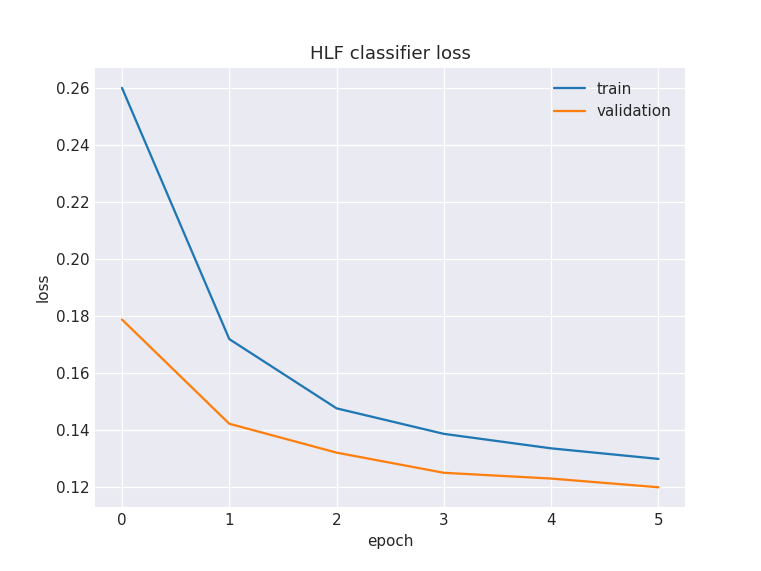

In [34]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


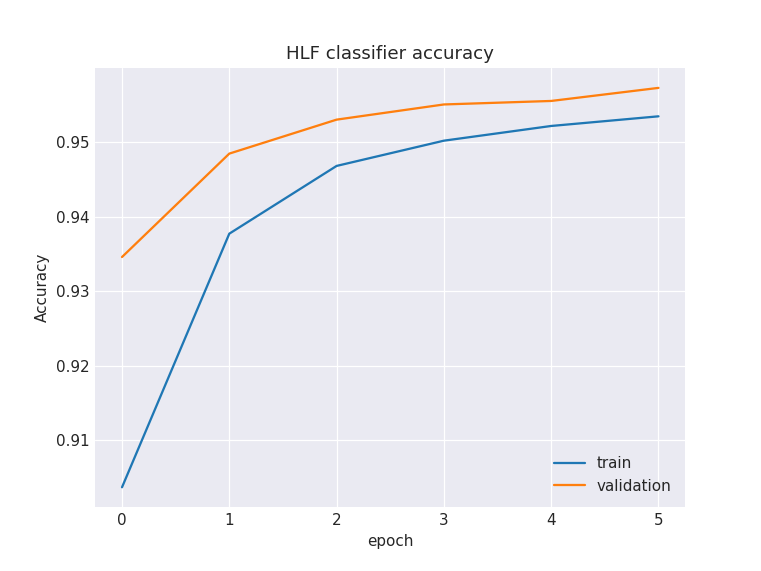

In [33]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [22]:
# model = tf.keras.models.load_model("./mymodel.tf")

In [23]:
# %time model.evaluate(test)

6689/6689 [==============================] - 418s 62ms/step - loss: 0.1199 - accuracy: 0.9572
CPU times: user 6min 24s, sys: 6min 31s, total: 12min 55s
Wall time: 6min 58s


[0.11986041069030762, 0.9572381377220154]

In [24]:
%time y_pred = model.predict(test)

CPU times: user 5min 50s, sys: 6min 26s, total: 12min 17s
Wall time: 6min 41s


In [25]:
%time y_true = np.stack([labels.numpy() for features,labels in parsed_test_dataset.__iter__()])

CPU times: user 6min 39s, sys: 6min 37s, total: 13min 17s
Wall time: 7min 8s


In [27]:
from sklearn.metrics import accuracy_score

print('Accuracy of the classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the classifier: 0.9572


/tmp/ipykernel_2335/950292951.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1)


<IPython.core.display.Javascript object>


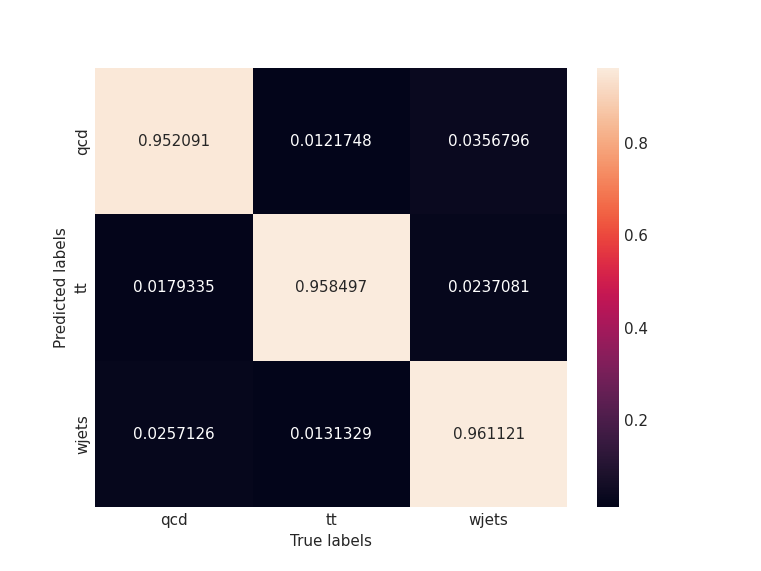

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [29]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [30]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9952043627713779, 1: 0.9968104469641463, 2: 0.9947245783743955}

<IPython.core.display.Javascript object>


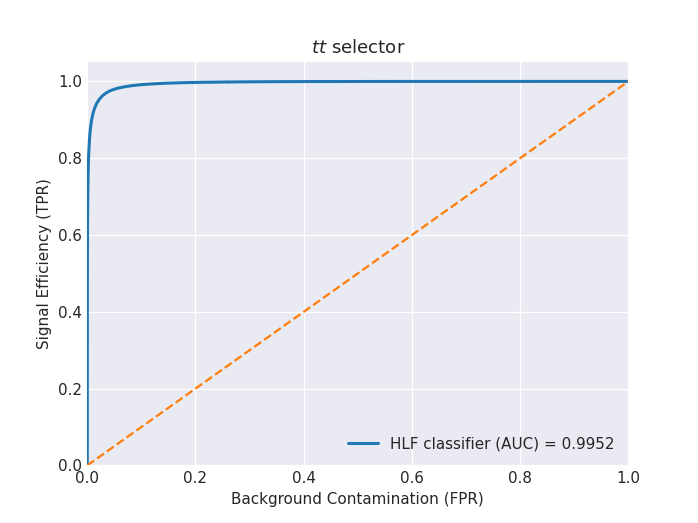

In [36]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()